# Breaking it Down: Logistic Regression

In this post, we will: 
- Define, break down, and implement Logistic Regression
- Load and prepare a heart disease dataset for our logistic regression classifier
- Construct the various components of the logistic regression classifier from scratch with NumPy
- Train the classifier to predict if a subject has heart disease based on input physiological metrics
- Use TensorFlow to create a formal logistic regression classifier

**Outline**
1. [What is Logistic Regression?](#1-what-is-logistic-regression)
2. [Getting Started - Loading and Preparing the Heart Disease Dataset](#2-getting-started---loading-and-preparing-the-heart-disease-dataset)
3. [Constructing the Logistic Regression Classifier](#3-constructing-the-logistic-regression-classifier)
    1. [Linear transformation](#31-linear-transformation)
    2. [Sigmoid Activation](#32-sigmoid-activation)
    3. [Binary Cross Entropy Cost Function](#33-binary-cross-entropy-cost-function)
    4. [Gradient Descent]()
    5. [Fitting the Model]()
4. Training and Testing the Classifier
5. Implementing Logistic Regression with TensorFlow

### 1. What is Logistic Regression?
[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) is a probabilistic classification algorithm that predicts labels to describe a set of input variables<sup>[1][stanford],[2][ng]</sup>. Often, logistic regression is used for binary labeling. For example, the input variables might be pixel values from an input image, and the output label could indicate whether the main subject of the image *is* or *is not* a cat.

Logistic (or logit) regression is a discriminative form of supervised machine learning, meaning that that it requires labeled training data. This training data is used to 'tune' the logit classifier to minimize the difference between the predicted labels and the true labels. This difference minimization is achieved through gradient descent.

Logistic regression is essentially a linear transformation of the input data followed by a non-linear transformation.

<p align="center">
<img src="images/cat_binary.png" width="50%"/><br>
<a href="https://pskp-95.github.io/2020/04/24/neural-network-and-deep-learning/">Source: PSKP's Blog</a>
</p>

[stanford]: https://web.stanford.edu/~jurafsky/slp3/5.pdf
[ng]: https://see.stanford.edu/materials/aimlcs229/cs229-notes1.pdf

Before getting started, I want to highlight some questions that I had when learning about logistic regression.

**Questions about Logistic Regression:**

>**Q1:** Isn't logistic regression basically just a single unit from a neural network?<br><br>
>**A1:** Effectively, yes. We can think of logistic regression as a single-layer, single-unit neural network. [Sebastian Raschka][logit_network] provides some nice insight into why this is so. In fact, many neural networks use sigmoid activation functions to generate unit outputs, just as logistic regression does.

>**Q2:** What do we mean by _logistic_?<br><br>
>**A2:** The 'logistic' of logistic regression comes from the fact that the model uses the inverse of the _logit_ function, aka the sigmoid function<sup>[3][logit]</sup>. 


[logit_network]: https://sebastianraschka.com/faq/docs/logisticregr-neuralnet.html
[logit]: https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102

### 2. Getting Started - Loading and Preparing the Heart Disease Dataset
Before we do anything, let's load our necessary packages.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

As an example dataset for our logistic regression classifier, we're going to be using the [Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease). We'll classify whether individuals do or don't have heart disease based on their input physiological measurements. The selected input physiological parameters shared from this dataset are described in detail [here](https://www.kaggle.com/datasets/nareshbhat/health-care-data-set-on-heart-attack-possibility). The variables from this dataset include age, sex, chest pain presence, cholesterol levels, and the number of major coronal vessels labeled during fluroscopy, among others.

Let's first load the dataset and inspect it for missing values, and we'll confirm that our classifications are truly binary (the `target` column).

In [19]:
df = pd.read_csv("heart.csv")

## IMPORTANT ## 
# The targets are flipped. Let's correct that
df.target = df.target.replace({0:1, 1:0})

print(f"Number of subjects: {df.shape[0]}")
print(f"Percentage of subjects diagnosed with heart disease: {df['target'].sum() / df.shape[0] * 100: 0.2f}%")
print(f"Number of NaN values in the dataset: {df.isnull().sum().sum()}")

df.head()

Number of subjects: 303
Percentage of subjects diagnosed with heart disease:  45.54%
Number of NaN values in the dataset: 0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


It's obvious that there are no missing values, and by plotting the data with Seaborn, we can see that there are some clear separations between the 'healthy' and 'disease' groups in several of examined metrics.

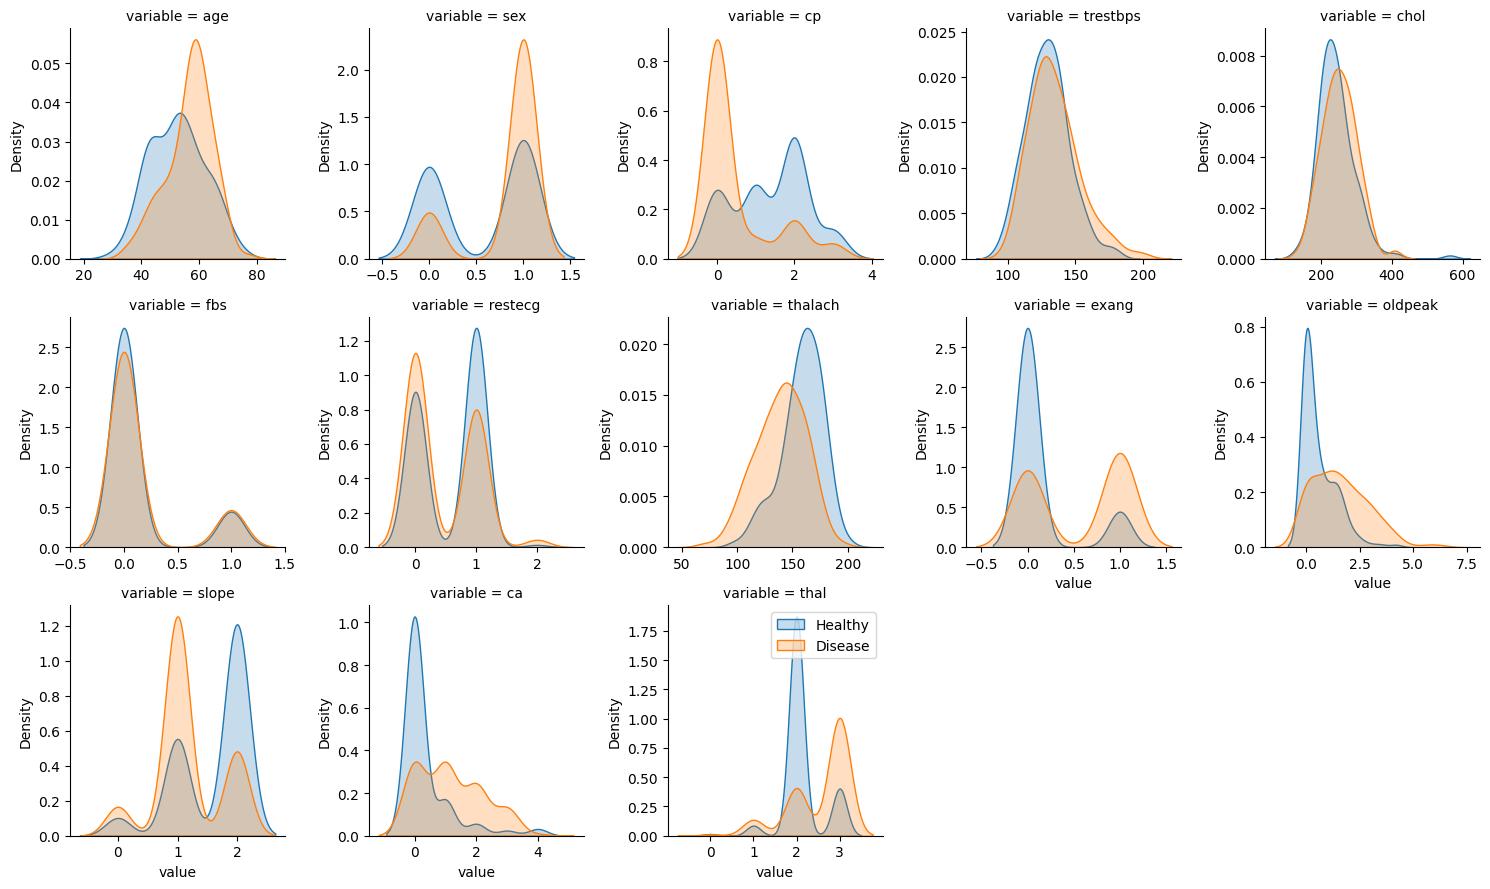

In [22]:
long_df = pd.melt(df, df.columns[-1], df.columns[:-1])

g = sns.FacetGrid(long_df, col="variable", hue="target", 
                  sharex=False, sharey=False, col_wrap=5)
g.map(sns.kdeplot, "value", shade=True)
plt.legend(labels=["Healthy", "Disease"])
plt.show()

It's clear that there are numerous features with obvious distribution differences between the subjects with and without heart disease diagnoses.

Before we move on to create our logistic regression model, we need to do two things to our dataset. First, we're going to create a 75%:25% test:train split. Then, we're going to normalize the continuous features of the dataset.

Importantly, we're going to identify the normalizing parameters from the training set, and these features will then be used to normalize the test set.

In [23]:
# 1. Split the dataset into train/test datasets.
targets = df.pop('target')

x_train, x_test, y_train, y_test = train_test_split(df, targets, test_size=.25)
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

# 2. Normalize the variables with continuous data with parameters from the train set
features_to_standardize = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

column_transformer = ColumnTransformer([('scaler', StandardScaler(), features_to_standardize)], remainder="passthrough")
x_train = column_transformer.fit_transform(x_train)
x_test = column_transformer.fit(x_test)

### 3. Constructing the Logistic Regression Classifier
The logistic regression model takes an input function, applies a linear transformation, applies a sigmoid activation function to that linear output, and then identifies the loss for the input. The model contains two variables: a **Weights** vector ($W$) and a **bias** ($b$) scalar. The **Weights** of the classifier indicate _how important_ each of the input variables are to the classification. The **bias** function is used to shift the placement of the linear decision boundary determined by the **Weights**. The **Weights** and **bias** variables will be 'tuned' during training.

The equation for the logistic regression is below, where the $\sigma$ represents the sigmoid function, and the $p(y=1)$ represents the probability that the input vector is the positive label (e.g., $y=1$ means the image _is_ a cat):

$$ p(y=1) = \sigma(W \cdot X + b)$$

Let's start by creating a logistic classifier class. This class will be bare-boned at first, but we'll later bind our created functions to it.

To start, we'll create an `__init__` function. This function will initialize our classifier with **Weights** and **Bias** variables both with starting values of 0.

Of note, our data are oriented such that individual samples are along rows. We need to keep track of this for our matrix multiplications.

In [24]:
class LogisticRegression:
    """A Logistic Regression classifier.
    
    Parameters:
        n_input_features
            The number of input features of the dataset. Assumes the features are
            oriented column-wise.
            
    Attributes:
        weights: np.ndarray
        
        bias: float
        
        fit: bool
    """
    def __init__(self, n_input_features: int):
        self.weights = np.zeros((n_input_features, 1))  # column matches X rows
        self.bias = 0
        
        self.fit = False  # indicates the training state of the classifier

#### 3.1 Linear Transformation
The linear transformation of logistic regression has two variables: the Weights variable and the bias variable. The Weights variable is an array with the same shape as the input data, and the bias variable is a single integer. Let's create a function that takes in the input variables, applies the linear transformation, and returns the scalar output.

$$ p(y=1) = \sigma(\underbrace{W \cdot X + b}_\text{Linear})$$

In [25]:
def linear_transform(self, X) -> np.ndarray:
    """Apply linear transformation to the input dataset and return the scalar output.
    
    Parameters:
        x: np.ndarray, pandas.DataFrame
            A 2D vector where the columns represent the features and the rows represent
            individual samples.
    
    Returns:
        np.ndarray
            The vector output of the linear transformation.
    """
    Z = np.matmul(X, self.weights) + self.bias
    return Z

LogisticRegression.linear_transform = linear_transform

#### 3.2 Sigmoid Activation
The sigmoid activation function takes a real input number and returns an output number scaled between 0 and 1. Monotonically increasing input variables return values that approach 1. The sigmoid function is seen below alongside the plotted function.

Importantly, this sigmoid function outputs a probability ($p$) that allows us to create classifications for the input features. When $p >= 0.5$, we classify $y = 1$, and when $p < 0.5$, we classify $y = 0$.

$$ p(y=1) = \underbrace{\sigma}_\text{Sigmoid}(W \cdot X + b)$$

$$ \sigma = \frac{1}{1+e^{-x}}$$

<p align="center">
<img src="images/sigmoid.png" width="35%"/>
</p>

In [26]:
def sigmoid(self, Z) -> np.ndarray:
    """Applies the sigmoid function to an input vector.
    
    Parameters:
        Z: np.ndarray 
    
    Returns:
        np.ndarray
            The a probability vector with the label prediction for each input sample
    """
    y_hat = 1 / (1 + np.exp(-Z))
    return y_hat

LogisticRegression.sigmoid = sigmoid

#### 3.3 Binary Cross Entropy Cost Function
The **Weights** and **bias** variables of the logistic regression model must be 'tuned' in order to appropriately classify the data. In order to 'tune' these parameters, we must define some function that will indicate whether the parameters did a 'good' or 'bad' job at transforming the input data for a subsequent classification.

Further, we operationally say that the cost should be *high* if the individual weights and bias did a bad job at predicting the label, and *low* if they did a good job.

The function that has been adopted for logistic regression is the **Binary Cross Entropy** function. The loss is computed individually for all input samples and is then averaged to create the cost.
$$L_{CE}(\hat{y}, y) = \frac{1}{m}\sum^{n}_{i=0}-y^{(i)}\log(\hat{y}^{(i)}) - (1-y^{(i)})(\log(1-\hat{y}^{(i)})$$

Notice that the loss function changes based on whether $y$ is $1$ or $0$. We want the cost to be minimal when the prediction matches the target. When $y = 1$, we just take the $log$ of the prediction, because if the prediction is correct, the $log$ will be $0$. When $y = 0$, we still want the cost to be low if the prediction is correct. However, because the $log$ produces large numbers with small decimals and is undefined at $0$, we can instead find the distance between the prediction and $1$. If the prediction for $y = 0$ is extremely close to zero, the cost will now be extremely low.

$$ loss = \begin{cases}
        y = 0 & -\log(1-\hat{y}^{(i)}) \\
        y = 1 & -\log(\hat{y}^{(i)})
    \end{cases}
$$

Importantly, we want the cost to be positive. Remember that the output of the sigmoid function is always between 0 and 1, and the $log$ of decimals is negative. As such, we multiple the output of the log by $-1$.

In [27]:
def compute_binary_cross_entropy_cost(self, Y_hat, Y) -> float:
    """Compute the binary cross entropy cost of a labeled dataset and predictions.
    
    Parameters:
        Y_hat: np.ndarray
            A vector of probabilities for each target.
        
        Y: np.ndarray, pandas.DataFram
            The ground truth target labels for each sample.
    
    Returns:
        float
            The binary cross entropy cost of the model.
    """
    epsilon = 1e-6  # add the epsilon to prevent divide by zero warnings
    m = Y.shape[0]
    y_0 = (1 - Y) * np.log(1 - Y_hat + epsilon)
    y_1 = - Y * np.log(Y_hat + epsilon)
    
    cost_sum = np.sum(y_0 - y_1)
    cost = 1 / m * cost_sum
    return cost

LogisticRegression.compute_binary_cross_entropy_cost = compute_binary_cross_entropy_cost



#### 3.4 Gradient Descent
Now that we can compute the cost of the model, we must use the cost to 'tune' our parameters via gradient descent. 

For example, if we look at our plotted data from the heart disease dataset above, we can see that the patient's resting blood pressure (`trestbps`) isn't a great indicator of heart disease, whereas the presence of exercise-induced chest pain (`exang`) is a much better indicator. 

Gradient descent will ensure that the weight for the `exang` feature is greater than the weight for the `trestbps` feature. 

By plotting the two sides of the binary cross entropy cost function, we can see that it is a convex function that will contain a single global minima.

<p align="center">
<img src="images/bce_cost.png" width="50%"/><br>
<a href="https://www.baeldung.com/cs/gradient-descent-logistic-regression">Source: Baeldung CS</a>
</p>

The goal in gradient descent is to minimize the cost of the function. To minimize the cost, we will compute the average gradient of each of the input parameters over the entire training set, and we'll use the averaged gradients to update the parameters. For a review of the foundations of gradient descent, check out my [Breaking it Down: Gradient Descent] post! To compute the gradients of the cost function with respect to the **Weights** and **Bias** parameters, we'll have to use the [Chain Rule].

In [ ]:
def backpropagate(self, X: np.ndarray, Z: np.ndarray, cost: float, learning_rate=0.01) -> None:
    """Run a single a back propagation of the model.
    
    Args:
        X (np.ndarray): The array containing the training data.
        Z (np.ndarray): The output from the linear transformation.
        cost (float): The cost of the previous forward propagation.
        learning_rate (float, optional): The learning rate of the backprop. Defaults to
            0.01.
            
    """
    # First compute dA with the derivative of the cost function 
    dA = None
    
    # Then compute dZ
    sigZ = self.sigmoid(Z)
    dZ = sigZ * (1 - sigZ)
    
    # Then compute dW and dB and apply the chain rule
    dW = X * dZ * dA
    dB = 1 * dZ * dA
    
    self.weights -= dW * learning_rate
    self.biases -= dB * learning_rate
    return

In [28]:
model = LogisticRegression(n_input_features=13)
model.

In [9]:
classifier = LogisticRegression(x_train.shape[1])
z = classifier.linear_transform(x_train)
probs = classifier.sigmoid(z)
y_train.to_numpy()``
cost = classifier.compute_binary_cross_entropy_cost(y_train.to_numpy(), y_train.to_numpy())



AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'